## This notebook builds a new data selection framework to build batting_runs inferential_models

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Image

# import jupyter_black
# jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
# warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import simplefilter, warn

simplefilter("ignore")

In [2]:
import os
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor/notebooks'

In [3]:
os.chdir("..")
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor'

In [4]:
from utils.config_utils import ConfigUtils
from historical_data.singleton import Helper
from data_selection.data_selection import DataSelection
from rewards_configuration.rewards_configuration import RewardsConfiguration
from simulators.perfect_simulator import PerfectSimulator

In [5]:
import aesara.tensor as at

In [6]:
config_utils = ConfigUtils(".streamlit/config.toml")
helper = Helper(config_utils)
data_selection = DataSelection(helper)
rewards_config = RewardsConfiguration(config_utils)
perfect_simulator = PerfectSimulator(data_selection, rewards_config)

2022-11-16 12:57:27.852 INFO    root: Creating feedback form storage with method local


In [7]:
helper.tournaments.df

,key,name,first_match_date,last_match_date
0,t20s,International T20s,2005-02-17,2022-10-05
1,apl,Afghanistan Premier League,2018-10-05,2018-10-21
2,bbl,Big Bash League,2011-12-16,2022-01-28
3,bpl,Bangladesh Premier League,2012-02-11,2022-02-18
4,cpl,Caribbean Premier League,2013-07-30,2022-09-30
5,ctc,CSA T20 Challenge,2012-02-15,2022-02-27
6,ipl,Indian Premier League,2008-04-18,2022-05-29
7,lpl,Lanka Premier League,2020-11-26,2021-12-23
8,psl,Pakistan Super League,2016-02-04,2022-02-27
9,ssm,Super Smash,2013-01-20,2022-01-29


In [8]:
selected_tournament = 'Indian Premier League'
tournament_start_date = helper.tournaments.df.query(f'name == "{selected_tournament}"').first_match_date.iloc[0]
tournament_end_date = helper.tournaments.df.query(f'name == "{selected_tournament}"').last_match_date.iloc[0]

In [9]:
helper.tournaments.set_selected_tournament_names([selected_tournament])
helper.tournaments.set_start_end_dates(tournament_start_date, tournament_end_date, False)

In [10]:
helper.tournaments.get_selected_tournaments()

['ipl']

In [11]:
helper.tournaments.get_start_end_dates(False)

(datetime.date(2008, 4, 18), datetime.date(2022, 5, 29))

In [12]:
all_matches_for_tournament = data_selection.get_selected_matches(False)

In [13]:
all_bowling_outcomes_for_tournament = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(False)
all_match_states_for_tournament = perfect_simulator.get_match_state_by_ball_and_innings(False)

In [14]:
all_matches_for_tournament.season.value_counts()

2013       76
2012       74
2022       74
2011       73
2021       60
2019       60
2016       60
2014       60
2020/21    60
2018       60
2009/10    60
2015       59
2017       59
2007/08    58
2009       57
Name: season, dtype: int64

In [15]:
test_season = '2018'

In [16]:
test_season_matches = all_matches_for_tournament.query(f'season == "{test_season}"')

In [17]:
test_start_date = test_season_matches.date.min()
test_end_date = test_season_matches.date.max()

In [18]:
(test_start_date,test_end_date)

(datetime.date(2018, 4, 7), datetime.date(2018, 5, 27))

In [19]:
test_season_venues = test_season_matches.venue.unique().tolist()
test_season_match_keys = test_season_matches.key.unique().tolist()

In [20]:
test_season_match_state_df = all_match_states_for_tournament.query('match_key in @test_season_match_keys')
test_season_bowling_outcomes_df = all_bowling_outcomes_for_tournament.query('match_key in @test_season_match_keys')

In [21]:
test_season_batters = test_season_match_state_df.batter.unique().tolist()
test_season_bowlers = test_season_match_state_df.bowler.unique().tolist()

In [22]:
previous_season = '2007/08'
previous_season_matches = all_matches_for_tournament.query(f'season == "{previous_season}"')
previous_season_end_date = previous_season_matches.date.max()

In [23]:
previous_season_end_date

datetime.date(2008, 6, 1)

In [24]:
#Now we know all the batters, bowlers and venues that we need to query for training data.
#So we choose all tournaments and set the training window to precede the test window
helper.tournaments.set_selected_tournament_names(helper.tournaments.df.name.tolist())
helper.tournaments.set_start_end_dates(helper.tournaments.df.first_match_date.min(), 
                                       test_start_date, 
                                       False)


In [25]:
helper.tournaments.get_selected_tournaments()

['t20s',
 'apl',
 'bbl',
 'bpl',
 'cpl',
 'ctc',
 'ipl',
 'lpl',
 'psl',
 'ssm',
 'ntb',
 'msl']

In [26]:
helper.tournaments.get_start_end_dates(False)

(datetime.date(2005, 2, 17), datetime.date(2018, 4, 7))

In [27]:
helper.tournaments.get_start_end_dates(True)

(datetime.date(2005, 2, 17), datetime.date(2022, 10, 5))

In [28]:
am = data_selection.get_selected_matches(False)

In [29]:
(am.date.min(),am.date.max())

(datetime.date(2005, 2, 17), datetime.date(2018, 4, 7))

In [30]:
unqualified_train_bowling_outcomes_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(False)
unqualified_train_match_state_df = perfect_simulator.get_match_state_by_ball_and_innings(False)

In [31]:
unqualified_train_bowling_outcomes_df.shape

(603550, 20)

In [32]:
is_test_season_venue = unqualified_train_match_state_df.venue.isin(test_season_venues)
is_test_season_batter = unqualified_train_match_state_df.batter.isin(test_season_batters)
is_test_season_bowler = unqualified_train_match_state_df.bowler.isin(test_season_bowlers)

In [33]:
train_match_state_df = unqualified_train_match_state_df.loc[is_test_season_venue | is_test_season_batter | is_test_season_bowler]
train_bowling_outcomes_df = unqualified_train_bowling_outcomes_df.loc[is_test_season_venue | is_test_season_batter | is_test_season_bowler]

In [34]:
frequent_players_set = set(test_season_batters + test_season_bowlers)

In [35]:
train_match_state_df.shape

(243125, 2066)

In [36]:
train_match_state_df.query('bowler in @test_season_bowlers').shape

(115794, 2066)

In [37]:
train_bowlers = train_match_state_df.bowler.unique().tolist()
train_batters= train_match_state_df.batter.unique().tolist()

In [38]:
test_season_match_state_df.query('batter in @train_batters').shape

(13727, 419)

In [39]:
test_season_match_state_df.query('bowler in @train_bowlers').shape

(13468, 419)

In [40]:
test_season_match_state_df.shape

(14286, 419)

## Building new features and targets

In [41]:
def batter_featured_id(df):
    c1 = df['batter'].isin(frequent_players_set)
    df.loc[c1,'batter_featured_id'] = df['batter']
    df['batter_featured_id'].fillna('non_frequent_player',inplace=True)
    
def bowler_featured_id(df):
    c1 = df['batter'].isin(frequent_players_set)
    df.loc[c1,'bowler_featured_id'] = df['bowler']
    df['bowler_featured_id'].fillna('non_frequent_player',inplace=True)
    
def is_legal_delivery(df):
    c1 = df.noballs.isna() 
    c2 = df.wides.isna()
    df.loc[c1&c2,'is_legal_delivery'] = True
    df['is_legal_delivery'].fillna(False,inplace=True)
    
def striker_dismissed(df):
    c1 = (df['batter'] == df['player_dismissed'])
    c2 = (df['player_dismissed'].isna()==False)
    df.loc[c1&c2,'striker_dismissed'] = True
    c3 = (df['batter'] != df['player_dismissed'])
    df.loc[c3 & c2,'striker_dismissed'] = False

def innings_strike_rate(df):
    df['innings_strike_rate'] = df['current_total']/df['total_balls_bowled']
    df['innings_strike_rate'].fillna(0,inplace=True)
    max_value = np.nanmax(df[['innings_strike_rate']][df['innings_strike_rate'] != np.inf])
    df['innings_strike_rate'].replace([np.inf, -np.inf], max_value, inplace=True)

    
def add_column_to_df(df,
                     column_name):
    column_name(df)

In [42]:
for df in [train_match_state_df,
           test_season_match_state_df]:
    for column in [batter_featured_id,
                   bowler_featured_id,
                   innings_strike_rate]:
        add_column_to_df(df,
                         column)

In [43]:
for df in [train_bowling_outcomes_df,
           test_season_bowling_outcomes_df]:
    for column in [is_legal_delivery,
                   striker_dismissed]:
        add_column_to_df(df,
                         column)

In [44]:
for df in [train_match_state_df,
           test_season_match_state_df,
           train_bowling_outcomes_df,
           test_season_bowling_outcomes_df]:
    df.reset_index(inplace=True)

In [45]:
train_match_state_df.innings_strike_rate.max()

11.0

## Building Categoricals for Indexing

In [46]:
def build_categoricals_for_column(df,column):
    categorical = pd.Categorical(df[column])
    return categorical.categories
    
def get_categorical_column_index_for_df(df,
                            categories,
                            column):
    idx = pd.Categorical(df[column],
                         categories).codes
    return idx

In [47]:
COORDS = {}
train_feature_data = {}
test_feature_data = {}
all_feature_data = {}
for dim in ['batter_featured_id',
            'bowler_featured_id',
            'batting_team',
            'bowling_team',
            'venue',
            'wickets_fallen',
            'over',
            'match_key',
            'inning',
            'ball']:
    categories = build_categoricals_for_column(test_season_match_state_df,
                                               dim)
    COORDS[dim] = categories
    train_feature_data[dim] = get_categorical_column_index_for_df(train_match_state_df,
                                                                  categories,
                                                                  dim)
    test_feature_data[dim] = get_categorical_column_index_for_df(test_season_match_state_df,
                                                              categories,
                                                              dim)

In [48]:
for dim in ['innings_strike_rate']:
    train_feature_data[dim] = train_match_state_df[dim]
    test_feature_data[dim] = test_season_match_state_df[dim]

In [49]:
train_outcome_data = {}
test_outcome_data = {}
all_outcome_data = {}
for dim in ['batter_runs',
            'extras',
            'is_legal_delivery',
            'is_wicket',
            'wides',
            'noballs',
            'dismissal_kind',
            'is_direct_runout']:
    categories = build_categoricals_for_column(train_bowling_outcomes_df,
                                               dim)
    COORDS[dim] = categories
    train_outcome_data[dim] = get_categorical_column_index_for_df(train_bowling_outcomes_df,
                                                                  categories,
                                                                  dim)
    test_outcome_data[dim] = get_categorical_column_index_for_df(test_season_bowling_outcomes_df,
                                                              categories,
                                                              dim)

In [50]:
COORDS

{'batter_featured_id': Index(['ADa301', 'AFh613', 'AHs158', 'AMa1185', 'ANh3559', 'APl721', 'ARe1184',
        'ARl347', 'ARt3533', 'ARu2333',
        ...
        'TCn166', 'TSe731', 'UYv970', 'VKi607', 'VSr1177', 'WSa3464', 'WSr946',
        'YCl723', 'YPn1126', 'YSh604'],
       dtype='object', length=138),
 'bowler_featured_id': Index(['ADa301', 'AKn1993', 'AMa1185', 'APl721', 'ARl347', 'ARt3533',
        'ASa3470', 'ASh3500', 'ATe175', 'BCg443', 'BKr287', 'BLn1978', 'BSe177',
        'BSn2331', 'BSs594', 'BTi3476', 'CAn1189', 'CBe1188', 'CDa2236',
        'CJn164', 'CMs600', 'CWs853', 'CdGe729', 'DBo344', 'DCn836', 'DCr947',
        'DHa1844', 'DKi2334', 'DSt169', 'DWy163', 'GMl156', 'HPa719', 'HPl969',
        'HSh1465', 'ISi402', 'ITr445', 'JAr1899', 'JBh724', 'JDy599', 'JSs3190',
        'JUt2172', 'KAd1449', 'KAf3656', 'KGm3511', 'KKa3650', 'KPa1178',
        'KSa2406', 'KYv289', 'LNi966', 'LPt478', 'MAi595', 'MAn3471', 'MJn710',
        'MLr3566', 'MMe2765', 'MMn784', 'MNi204'

In [51]:
train_feature_data

{'batter_featured_id': array([17, 17, 17, ..., 57, 57, 57], dtype=int16),
 'bowler_featured_id': array([-1, -1, -1, ..., 58, 58, 58], dtype=int8),
 'batting_team': array([-1, -1, -1, ...,  0,  0,  0], dtype=int8),
 'bowling_team': array([-1, -1, -1, ...,  4,  4,  4], dtype=int8),
 'venue': array([-1, -1, -1, ...,  9,  9,  9], dtype=int8),
 'wickets_fallen': array([0, 0, 0, ..., 9, 9, 9], dtype=int8),
 'over': array([ 0,  0,  0, ..., 19, 19, 19], dtype=int8),
 'match_key': array([-1, -1, -1, ...,  0,  0,  0], dtype=int8),
 'inning': array([1, 1, 1, ..., 1, 1, 1], dtype=int8),
 'ball': array([0, 1, 2, ..., 2, 3, 4], dtype=int8),
 'innings_strike_rate': 0         0.000000
 1         0.000000
 2         0.500000
 3         0.400000
 4         1.000000
             ...   
 243120    1.336134
 243121    1.325000
 243122    1.314050
 243123    1.352459
 243124    1.373984
 Name: innings_strike_rate, Length: 243125, dtype: float64}

In [52]:
test_feature_data

{'batter_featured_id': array([102, 102, 102, ...,   9,   9,   9], dtype=int16),
 'bowler_featured_id': array([25, 25, 25, ..., 17, 17, 17], dtype=int8),
 'batting_team': array([4, 4, 4, ..., 0, 0, 0], dtype=int8),
 'bowling_team': array([0, 0, 0, ..., 7, 7, 7], dtype=int8),
 'venue': array([9, 9, 9, ..., 9, 9, 9], dtype=int8),
 'wickets_fallen': array([0, 0, 0, ..., 2, 2, 2], dtype=int8),
 'over': array([ 0,  0,  0, ..., 18, 18, 18], dtype=int8),
 'match_key': array([ 0,  0,  0, ..., 59, 59, 59], dtype=int8),
 'inning': array([0, 0, 0, ..., 1, 1, 1], dtype=int8),
 'ball': array([0, 1, 2, ..., 0, 1, 2], dtype=int8),
 'innings_strike_rate': 0        0.000000
 1        0.000000
 2        0.000000
 3        1.333333
 4        1.250000
            ...   
 14281    1.623853
 14282    1.609091
 14283    1.594595
 14284    1.580357
 14285    1.601770
 Name: innings_strike_rate, Length: 14286, dtype: float64}

In [53]:
def build_xarray(feature_dict,
                 outcome_dict,
                 index_df):
    feature_df = pd.DataFrame(feature_dict)
    feature_df.index = index_df.index
    outcome_df = pd.DataFrame(outcome_dict)
    outcome_df.index = index_df.index
    combined_df = pd.merge(outcome_df,
                           feature_df,
                           left_index = True,
                           right_index = True)
    return combined_df, combined_df.to_xarray()

In [54]:
train_combined_df,train_combined_xarray = build_xarray(train_feature_data,
                                                         train_outcome_data,
                                                         train_match_state_df)

In [55]:
test_combined_df,test_combined_xarray = build_xarray(test_feature_data,
                                                         test_outcome_data,
                                                         test_season_match_state_df)

In [65]:
test_combined_df.query('is_legal_delivery == 0').batter_runs.value_counts(normalize=True)

0    0.958159
1    0.033473
6    0.006276
4    0.002092
Name: batter_runs, dtype: float64

In [62]:
test_combined_df.is_wicket.value_counts(normalize=True)

0    0.949461
1    0.050539
Name: is_wicket, dtype: float64

In [63]:
test_combined_df.is_legal_delivery.value_counts(normalize=True)

1    0.966541
0    0.033459
Name: is_legal_delivery, dtype: float64

<AxesSubplot: xlabel='batter_runs', ylabel='innings_strike_rate'>

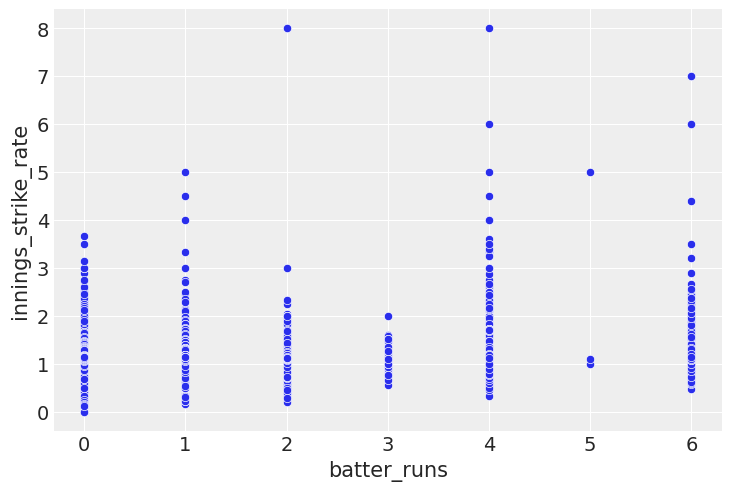

In [1371]:
sns.scatterplot(
    data = test_combined_df,
    x = 'batter_runs',
    y = 'innings_strike_rate'
)

<AxesSubplot: xlabel='batter_runs', ylabel='innings_strike_rate'>

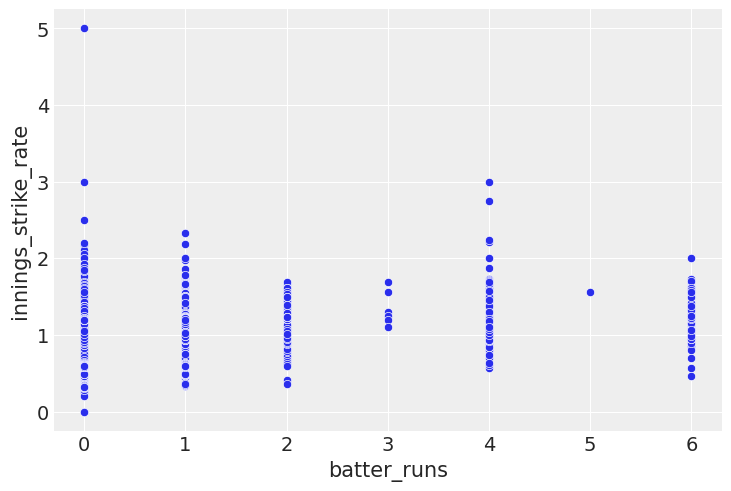

In [1372]:
sns.scatterplot(
    data = train_combined_df,
    x = 'batter_runs',
    y = 'innings_strike_rate'
)

<AxesSubplot: xlabel='wickets_fallen', ylabel='innings_strike_rate'>

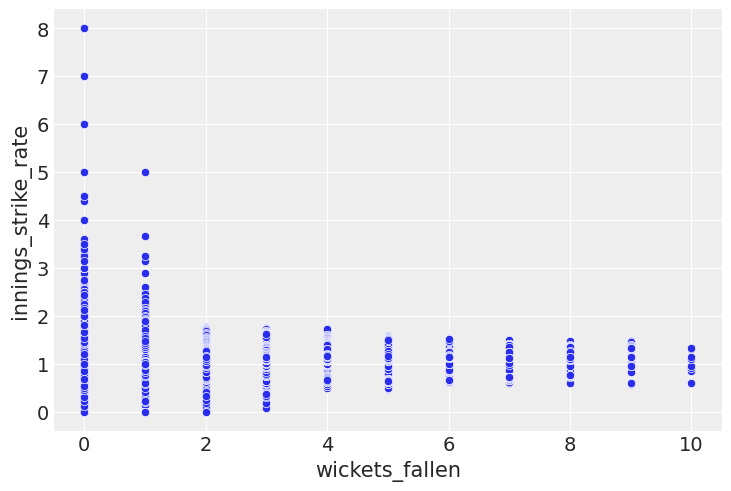

In [1373]:
sns.scatterplot(
    data = test_combined_df,
    x = 'wickets_fallen',
    y = 'innings_strike_rate'
)

<AxesSubplot: xlabel='wickets_fallen', ylabel='innings_strike_rate'>

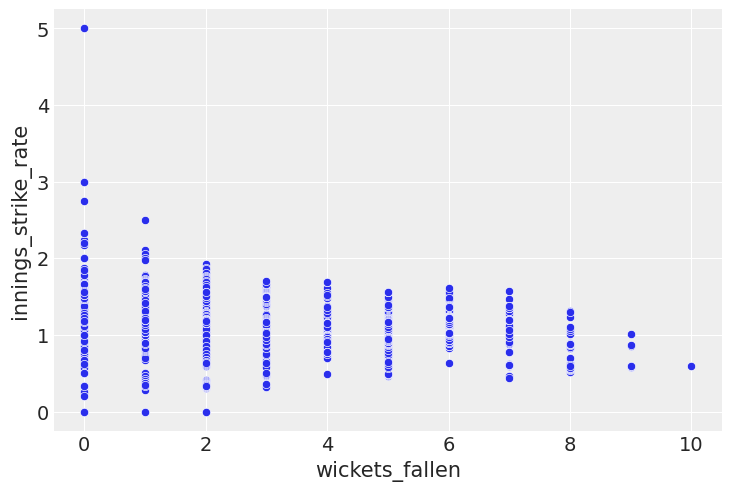

In [1374]:
sns.scatterplot(
    data = train_combined_df,
    x = 'wickets_fallen',
    y = 'innings_strike_rate'
)

## Adding Data to the PyMC Model

In [1375]:
with pm.Model(coords=COORDS) as first_innings_model:
    first_innings_model.add_coord('ball_ids',
                                   values = np.arange(train_combined_df.shape[0]),
                                   mutable = True)
    is_legal_delivery_outcomes_data = pm.MutableData("is_legal_delivery_outcomes_data",
                                                     train_combined_df['is_legal_delivery'],
                                                     dims = 'ball_ids')
    batter_runs_outcomes_data = pm.MutableData("batter_runs_outcomes_data",
                                               train_combined_df['batter_runs'],
                                               dims = 'ball_ids')
    batter_featured_id_feature_data = pm.MutableData("batter_featured_id_feature_data",
                                                     train_combined_df['batter_featured_id'],
                                                     dims = 'ball_ids')
    bowler_featured_id_feature_data = pm.MutableData("bowler_featured_id_feature_data",
                                                 train_combined_df['bowler_featured_id'],
                                                 dims = 'ball_ids')
    venue_feature_data = pm.MutableData("venue_feature_data",
                                        train_combined_df['venue'],
                                        dims = 'ball_ids')
    batting_team_feature_data = pm.MutableData("batting_team_feature_data",
                                    train_combined_df['batting_team'],
                                    dims = 'ball_ids')
    bowling_team_feature_data = pm.MutableData("bowling_team_feature_data",
                                    train_combined_df['bowling_team'],
                                    dims = 'ball_ids')
    over_feature_data = pm.MutableData("over_feature_data",
                                    train_combined_df['over'],
                                    dims = 'ball_ids')
    inning_feature_data = pm.MutableData("inning_feature_data",
                                    train_combined_df['inning'],
                                    dims = 'ball_ids')
    wickets_fallen_feature_data = pm.MutableData("wickets_fallen_feature_data",
                                train_combined_df['wickets_fallen'],
                                dims = 'ball_ids')

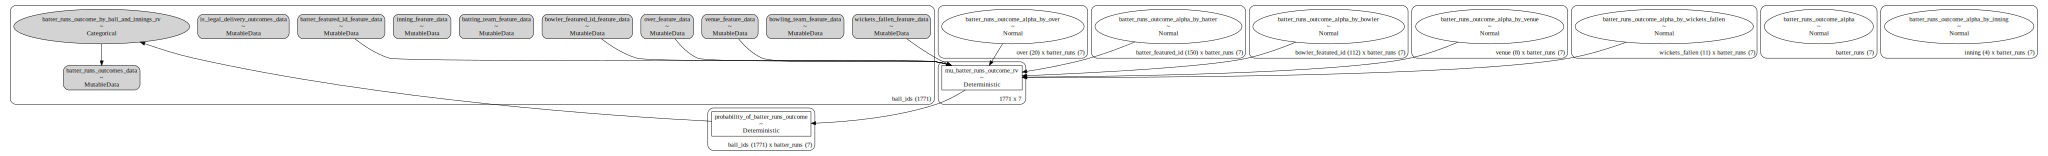

In [1376]:
with first_innings_model:
    batter_runs_outcome_alpha = pm.Normal('batter_runs_outcome_alpha',
                                         mu=0,
                                         sigma=3,
                                         dims='batter_runs')
    batter_runs_outcome_alpha_by_over = pm.Normal('batter_runs_outcome_alpha_by_over',
                                                mu = 0,
                                                sigma = 3.0,
                                                dims = ('over',
                                                        'batter_runs'))
    batting_team_aggression_slope_by_innings_strike_rate = pm.Normal('batting_team_aggression_slope_by_innings_strike_rate',
                                            mu = 0,
                                            sigma = 3.0,
                                                                    dims='batter_runs')
    bowling_team_aggression_slope_by_innings_strike_rate = pm.Normal('batting_team_aggression_slope_by_innings_strike_rate',
                                            mu = 0,
                                            sigma = 3.0,
                                                                    dims='is_wicket')
    batting_team_aggression = pm.Deterministic('batting_team_aggression',
                                               batting_team_aggression_slope_by_innings_strike_rate
                                               *innings_strike_rate_feature_data)
    
    batter_runs_outcome_alpha_sigma_by_batter_global = 3.0
    batter_runs_outcome_alpha_by_batter = pm.Normal('batter_runs_outcome_alpha_by_batter',
                                                    mu = batter_runs_outcome_alpha_mu_by_batter_global,
                                                    sigma = batter_runs_outcome_alpha_sigma_by_batter_global,
                                                    dims = ('batter_featured_id',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_inning = pm.Normal('batter_runs_outcome_alpha_by_inning',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('inning',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_bowler = pm.Normal('batter_runs_outcome_alpha_by_bowler',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('bowler_featured_id',
                                                            'batter_runs'))
    '''batter_runs_outcome_alpha_by_batting_team = pm.Normal('batter_runs_outcome_alpha_by_batting_team',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('batting_team',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_bowling_team = pm.Normal('batter_runs_outcome_alpha_by_bowling_team',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('bowling_team',
                                                            'batter_runs'))'''
    batter_runs_outcome_alpha_by_venue = pm.Normal('batter_runs_outcome_alpha_by_venue',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('venue',
                                                            'batter_runs'))

    batter_runs_outcome_alpha_by_wickets_fallen = pm.Normal('batter_runs_outcome_alpha_by_wickets_fallen',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('wickets_fallen',
                                                            'batter_runs'))
    batter_runs_outcome_mu = pm.Deterministic('mu_batter_runs_outcome_rv',
                                                        #batter_runs_outcome_alpha+
                                                        batter_runs_outcome_alpha_by_batter[batter_featured_id_feature_data]+
                                                        batter_runs_outcome_alpha_by_bowler[bowler_featured_id_feature_data]+
                                                        batter_runs_outcome_alpha_by_over[over_feature_data]+
                                                        batter_runs_outcome_alpha_by_wickets_fallen[wickets_fallen_feature_data]+
                                                        batter_runs_outcome_alpha_by_venue[venue_feature_data]+
                                                        batting_team_aggression)
    probability_of_batter_runs_outcome_rv = pm.Deterministic('probability_of_batter_runs_outcome',
                                                         at.nnet.softmax(batter_runs_outcome_mu),
                                                         dims = ('ball_ids','batter_runs'))
    batter_outcomes_by_ball_and_innings_rv = pm.Categorical('batter_runs_outcome_by_ball_and_innings_rv',
                                                         p=probability_of_batter_runs_outcome_rv,
                                                         observed=batter_runs_outcomes_data,
                                                         dims = 'ball_ids')

pm.model_to_graphviz(first_innings_model)

In [1377]:
with first_innings_model:
    idata = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
2022-11-16 10:27:39.144 INFO    pymc: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-11-16 10:27:39.146 INFO    pymc: Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2022-11-16 10:27:44.456 INFO    pymc: Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_over, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_inning, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha_by_wickets_fallen]
2022-11-16 10:27:44.458 INFO    pymc: NUTS: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_over, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_inning, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha_by_wickets_fallen]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 502 seconds.
2022-11-16 10:36:07.194 INFO    pymc: Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 502 seconds.


array([[<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n0'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n1'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n2'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n3'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n4'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n5'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n6'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

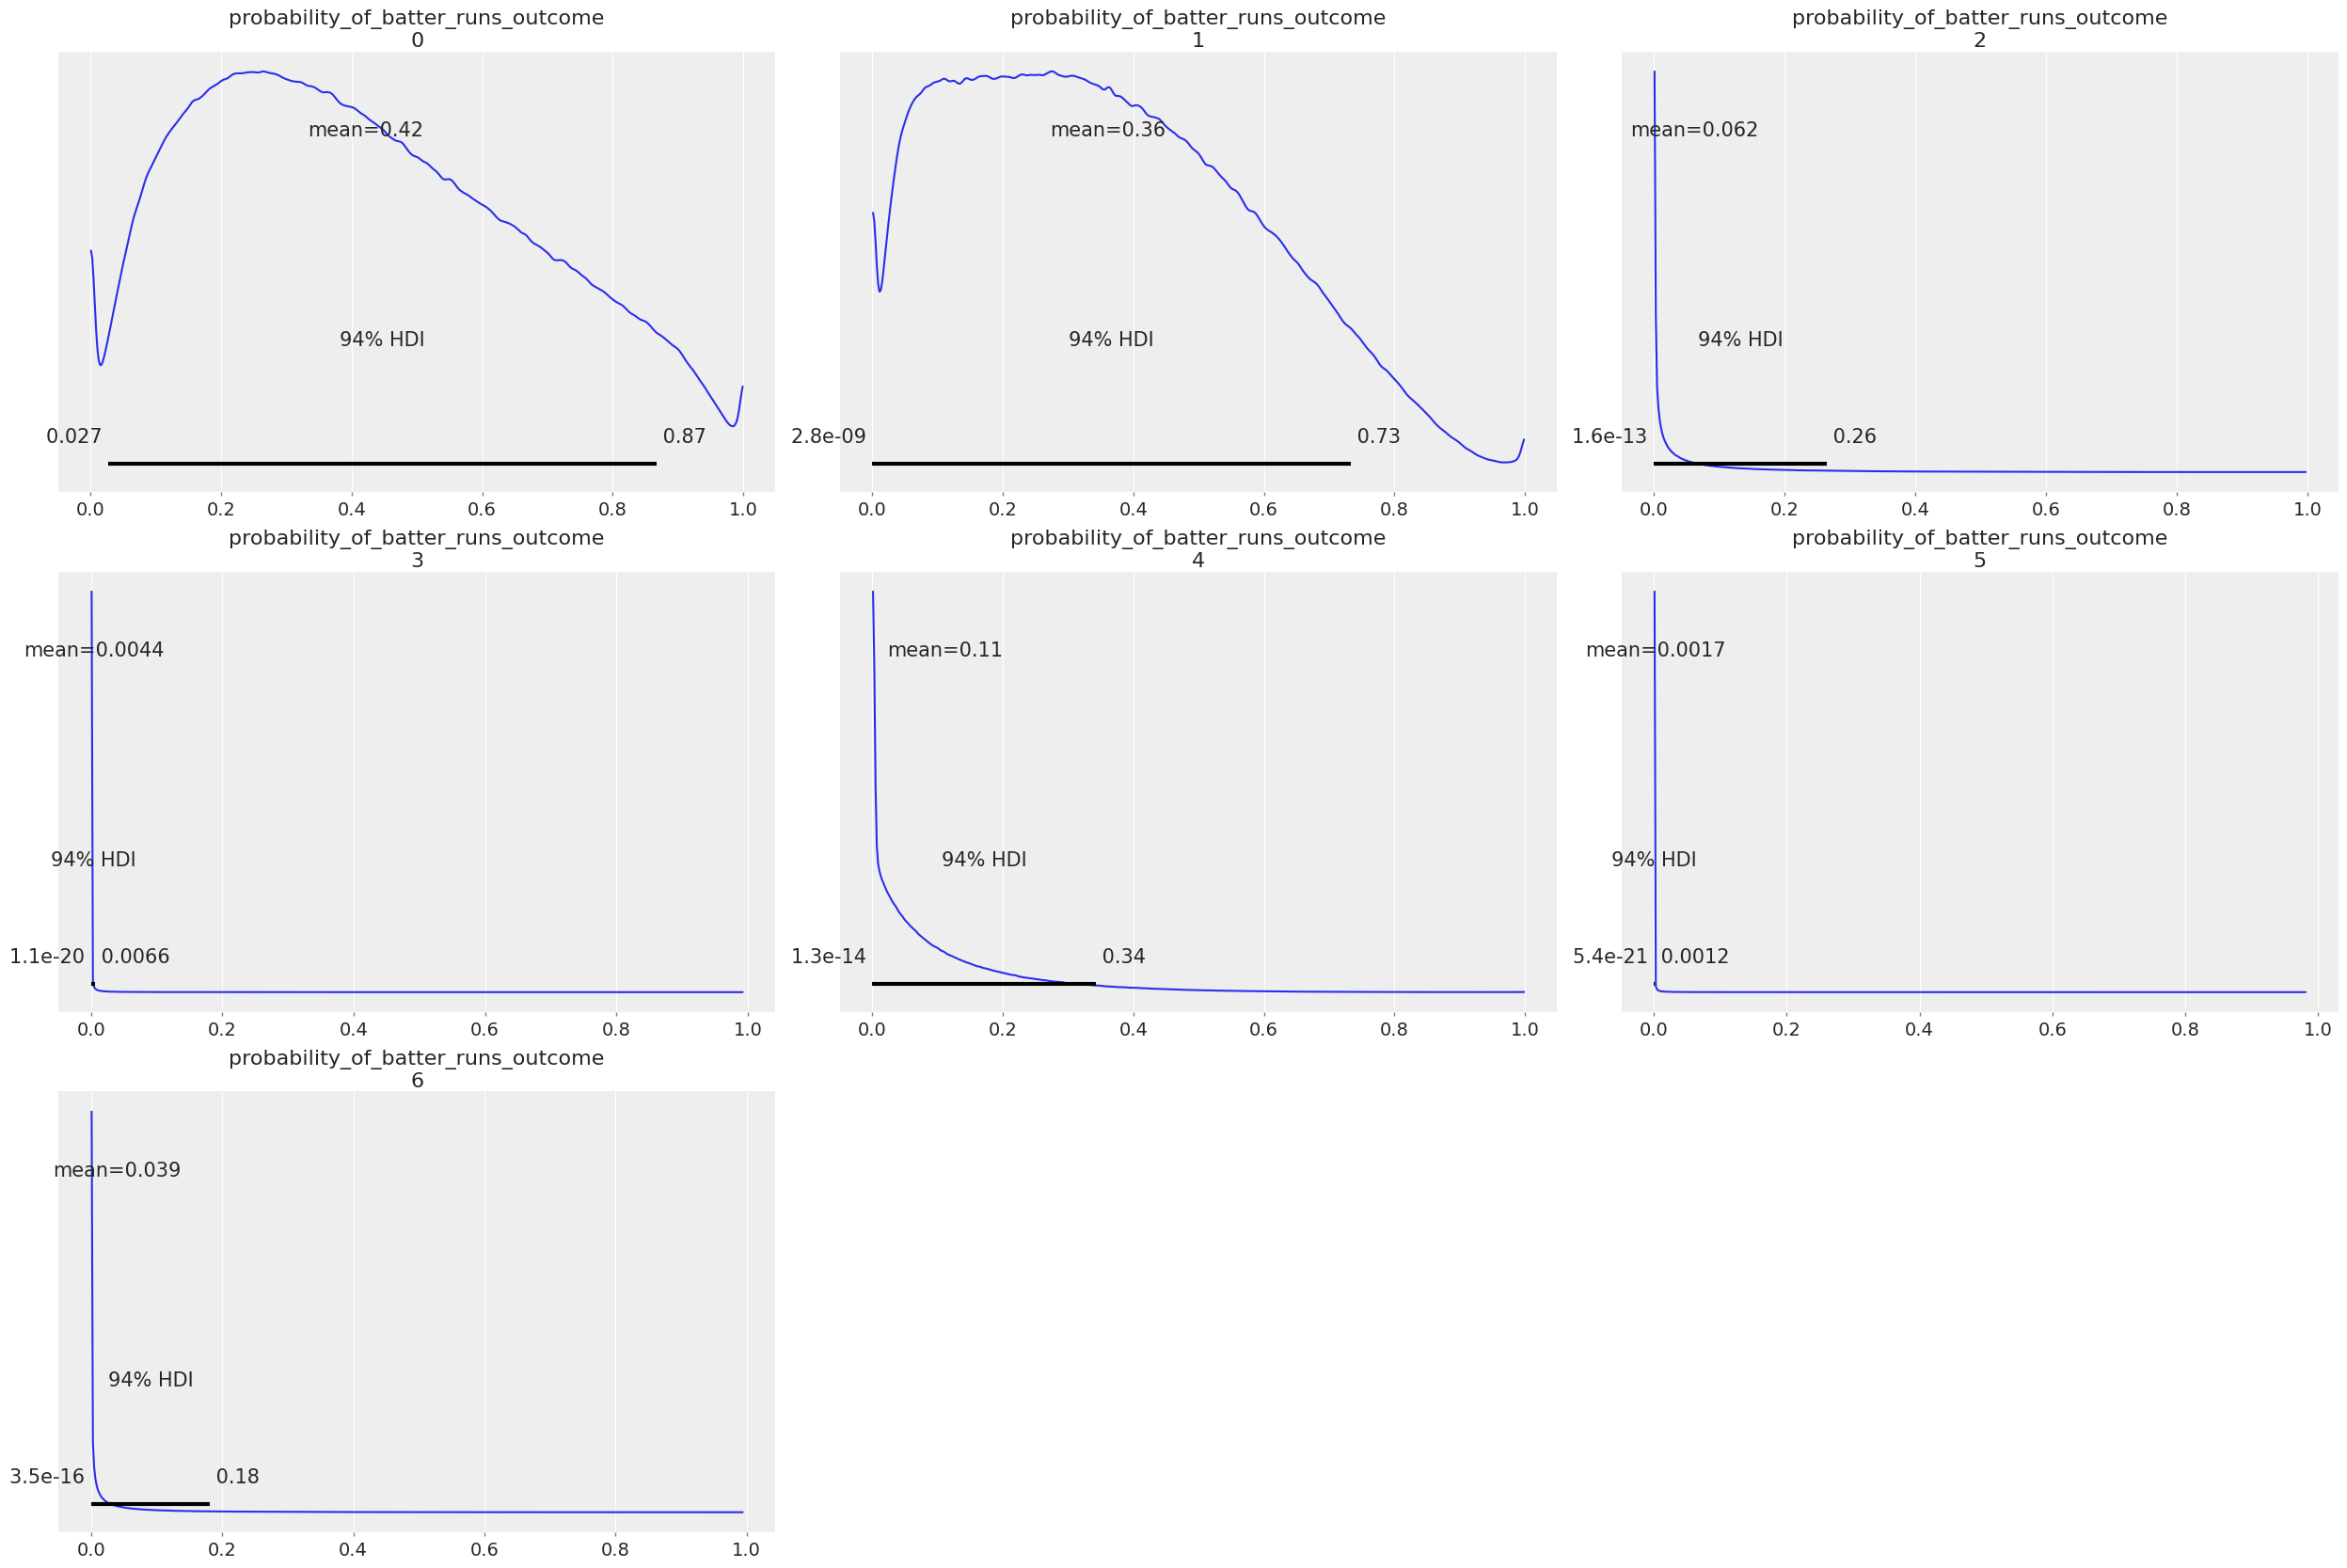

In [1378]:
az.plot_posterior(idata.posterior,
                  var_names = ['probability_of_batter_runs_outcome'],
                  combine_dims = {'chain','draw','ball_ids'})

<AxesSubplot: >

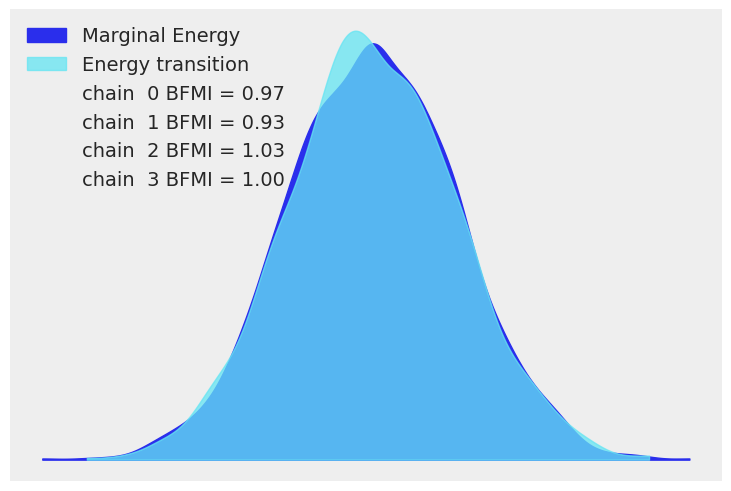

In [1379]:
az.plot_energy(idata)

In [1381]:
with first_innings_model:
    idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata.extend(pm.sample_posterior_predictive(idata,random_seed=RANDOM_SEED))

Sampling: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_inning, batter_runs_outcome_alpha_by_over, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha_by_wickets_fallen, batter_runs_outcome_by_ball_and_innings_rv]
2022-11-16 10:40:33.319 INFO    pymc: Sampling: [batter_runs_outcome_alpha, batter_runs_outcome_alpha_by_batter, batter_runs_outcome_alpha_by_bowler, batter_runs_outcome_alpha_by_inning, batter_runs_outcome_alpha_by_over, batter_runs_outcome_alpha_by_venue, batter_runs_outcome_alpha_by_wickets_fallen, batter_runs_outcome_by_ball_and_innings_rv]
Sampling: [batter_runs_outcome_by_ball_and_innings_rv]
2022-11-16 10:40:59.941 INFO    pymc: Sampling: [batter_runs_outcome_by_ball_and_innings_rv]


<AxesSubplot: xlabel='batter_runs_outcome_by_ball_and_innings_rv / batter_runs_outcome_by_ball_and_innings_rv'>

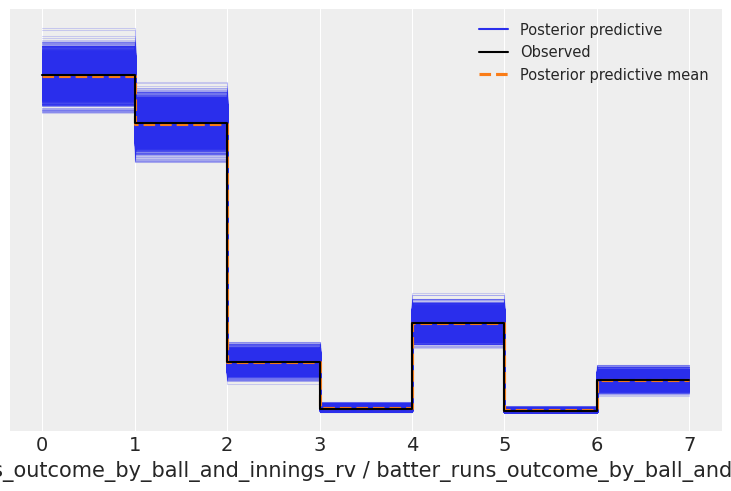

In [1382]:
az.plot_ppc(idata)

In [1383]:
first_innings_model.set_dim('ball_ids',
                             test_combined_df.shape[0],
                             coord_values = np.arange(train_combined_df.shape[0],
                                                      train_combined_df.shape[0]+test_combined_df.shape[0]))

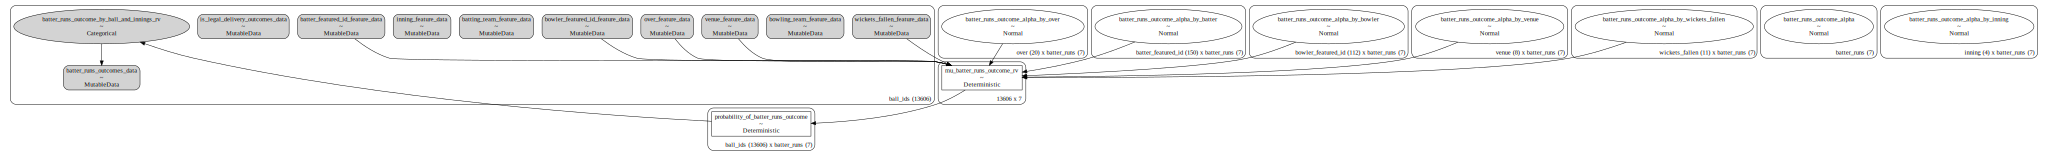

In [1384]:
with first_innings_model:
    pm.set_data({
        'batter_runs_outcomes_data': test_combined_df['batter_runs'],
        "batter_featured_id_feature_data": test_combined_df['batter_featured_id'],
        "bowler_featured_id_feature_data": test_combined_df['bowler_featured_id'],
        "batting_team_feature_data": test_combined_df['batting_team'],
        "bowling_team_feature_data": test_combined_df['bowling_team'],
        "venue_feature_data": test_combined_df['venue'],
        "is_legal_delivery_outcomes_data": test_combined_df['is_legal_delivery'],
        "over_feature_data": test_combined_df['over'],
        "inning_feature_data": test_combined_df['inning'],     
        "wickets_fallen_feature_data": test_combined_df['wickets_fallen'], 
    })

pm.model_to_graphviz(first_innings_model)

In [1385]:
with first_innings_model:
    idata = pm.sample_posterior_predictive(
            idata,
            predictions=True,
            extend_inferencedata=True,
            random_seed=RANDOM_SEED,
    )

Sampling: [batter_runs_outcome_by_ball_and_innings_rv]
2022-11-16 10:42:01.900 INFO    pymc: Sampling: [batter_runs_outcome_by_ball_and_innings_rv]


array([[<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1771'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1772'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1773'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1774'}>],
       [<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1775'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1776'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1777'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1778'}>],
       [<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1779'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1780'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_

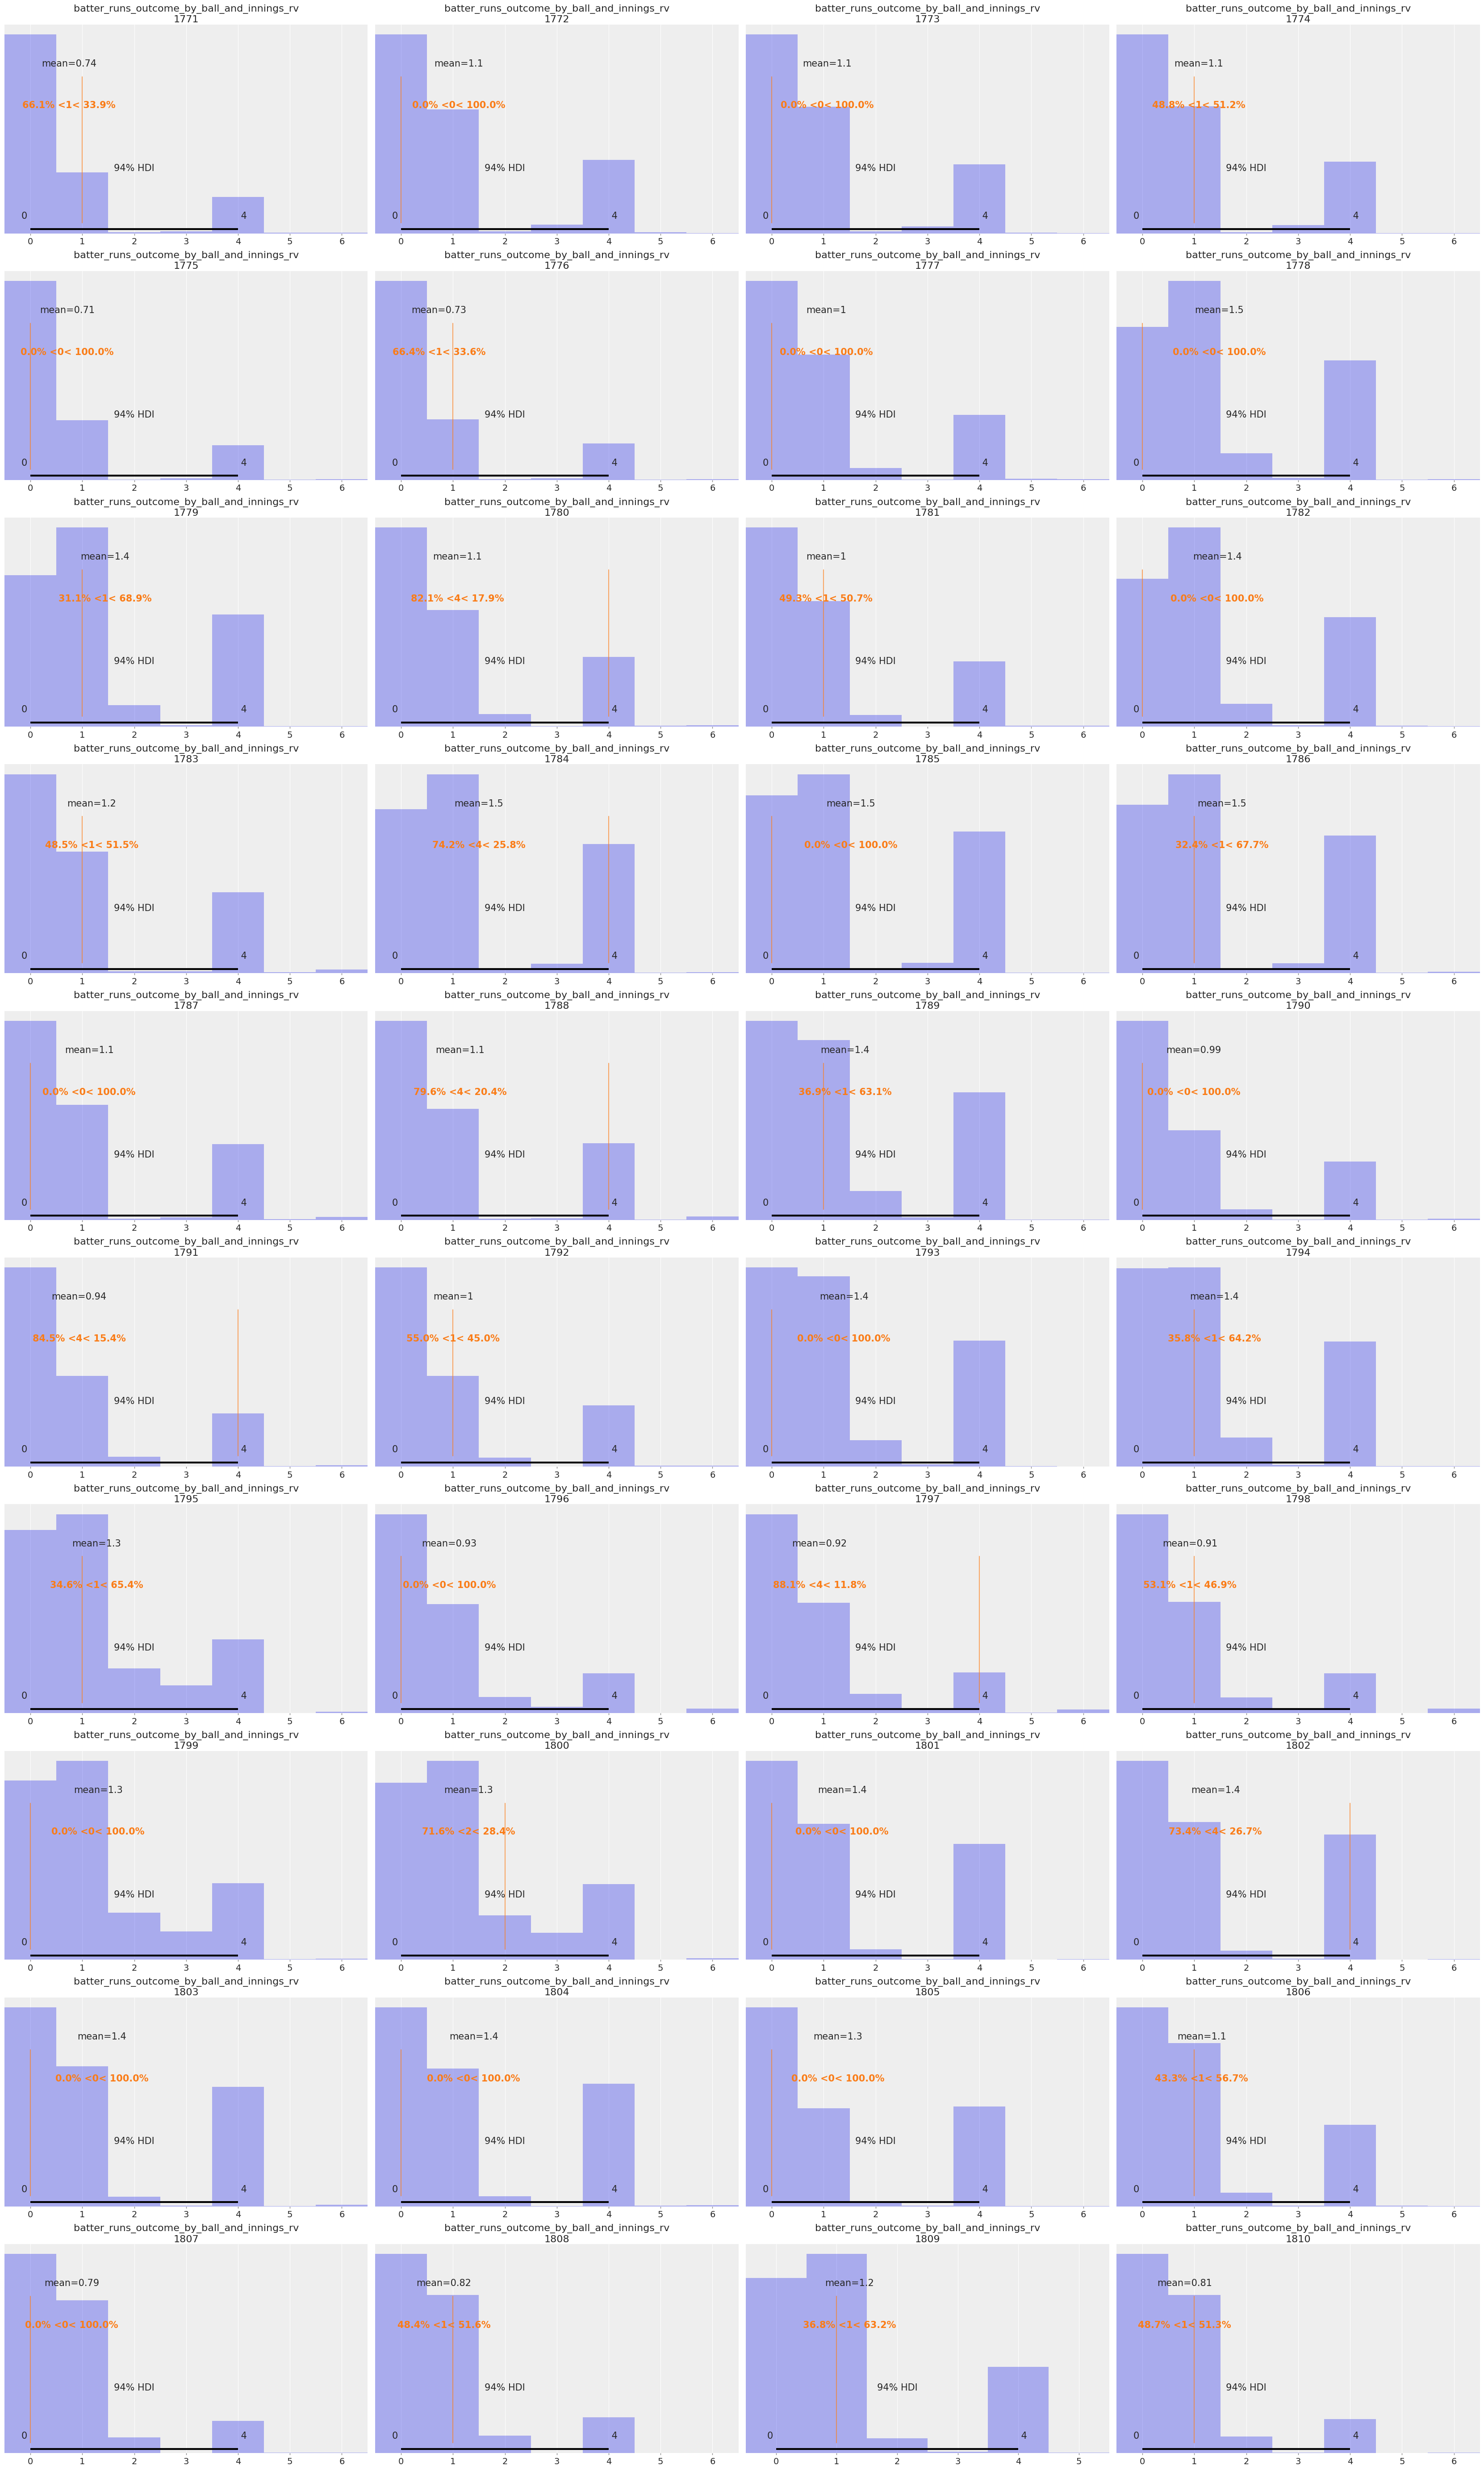

In [1386]:
az.plot_posterior(
    idata.predictions,
    ref_val=test_combined_df.batter_runs.tolist(),
)

<AxesSubplot: >

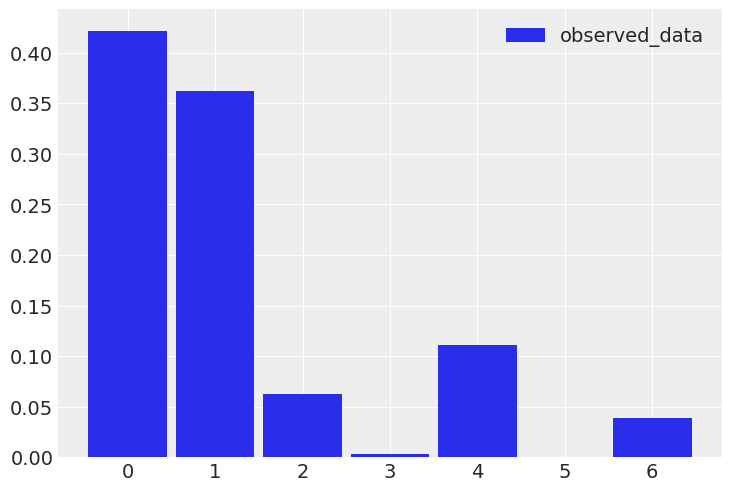

In [1387]:
az.plot_dist(idata.observed_data["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C0', 
             label='observed_data')

<AxesSubplot: >

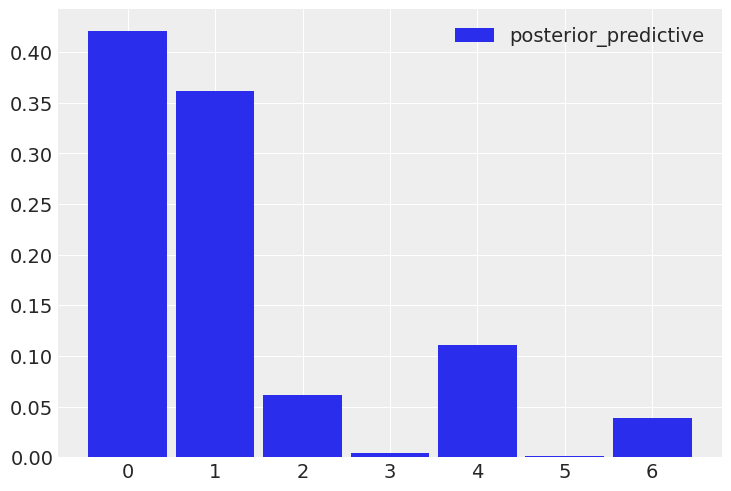

In [1388]:
az.plot_dist(idata.posterior_predictive["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C0', 
             label='posterior_predictive')

<AxesSubplot: >

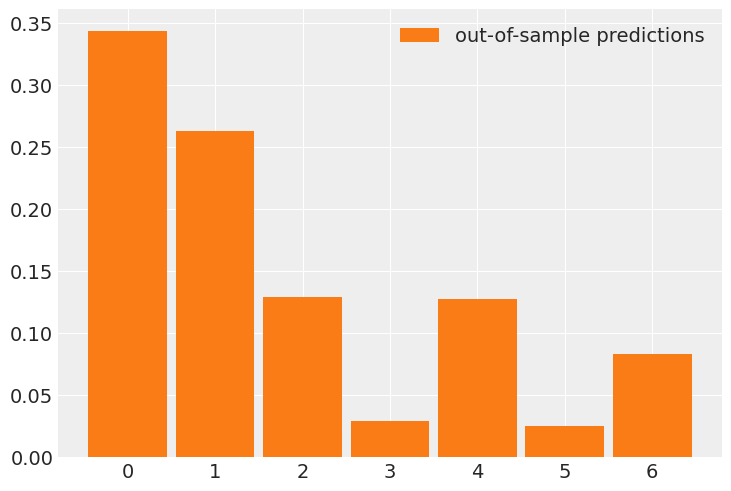

In [1389]:
az.plot_dist(idata.predictions["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C1', 
             label = 'out-of-sample predictions')

In [1390]:
def predictions_from_idata(idata,
                           var_name):
    preds_helper = lambda ds: ds.to_dataframe()[var_name].value_counts(normalize=True).to_xarray()
    predictions = (
        idata.predictions[var_name]
        .stack(dims=['chain','draw'])
        .groupby('ball_ids')
        .apply(preds_helper)
    )
    return predictions
    

In [1391]:
predictions = predictions_from_idata(idata,
                                     'batter_runs_outcome_by_ball_and_innings_rv')

In [1392]:
predictions

<xarray.DataArray 'batter_runs_outcome_by_ball_and_innings_rv' (
                                                                ball_ids: 13606,
                                                                index: 7)>
array([[6.61e-01, 2.02e-01, 3.25e-03, ..., 1.22e-01, 2.50e-03, 2.50e-03],
       [4.88e-01, 3.03e-01, 4.50e-03, ..., 1.80e-01, 2.50e-03, 5.00e-04],
       [4.92e-01, 3.14e-01, 4.50e-03, ..., 1.71e-01, 1.50e-03, 2.50e-04],
       ...,
       [6.68e-01, 2.83e-02, 6.22e-02, ..., 2.30e-02, 1.15e-02, 2.00e-01],
       [6.69e-01, 2.97e-02, 5.65e-02, ..., 2.25e-02, 1.00e-02, 2.07e-01],
       [6.73e-01, 2.83e-02, 6.12e-02, ..., 2.27e-02, 9.50e-03, 2.00e-01]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6
  * ball_ids  (ball_ids) int64 1771 1772 1773 1774 ... 15373 15374 15375 15376

In [1393]:
predictions_argmax = predictions.argmax('index')

In [1394]:
predictions_max = predictions.max('index')

In [1395]:
predictions_df = pd.DataFrame({'argmax':predictions_argmax.values,
                               'max':predictions_max.values})

In [1396]:
predictions_df

,argmax,max
0,0,0.66150
1,0,0.48775
2,0,0.49200
3,0,0.48825
4,0,0.67150
...,...,...
13601,0,0.67425
13602,0,0.67500
13603,0,0.66800
13604,0,0.66900


In [1399]:
from sklearn.metrics import classification_report, confusion_matrix
def print_cr_and_cm(true,pred):
    cr = classification_report(true,pred)
    cm = confusion_matrix(true,pred)
    print(cr)
    print(pd.DataFrame(cm))

In [1400]:
print_cr_and_cm(test_combined_df.batter_runs,
                predictions_argmax)

              precision    recall  f1-score   support

           0       0.49      0.60      0.54      5859
           1       0.42      0.35      0.38      4861
           2       0.08      0.09      0.08       994
           3       0.00      0.00      0.00        60
           4       0.10      0.04      0.05      1321
           5       0.00      0.00      0.00         3
           6       0.06      0.07      0.07       508

    accuracy                           0.40     13606
   macro avg       0.16      0.16      0.16     13606
weighted avg       0.38      0.40      0.38     13606

      0     1    2   3    4  5    6
0  3542  1467  439  33  199  0  179
1  2249  1701  486  30  156  1  238
2   447   344   91   4   43  0   65
3    30    18    3   0    3  0    6
4   725   357  117   9   49  0   64
5     2     1    0   0    0  0    0
6   218   173   48   4   29  0   36


In [1401]:
test_combined_no_idx = test_combined_df.reset_index()

In [1402]:
def performance_for_idx(selection_idx,
                        prediction_df,
                        true_df):
    true_above_threshold = true_df.loc[selection_idx].batter_runs
    predicted_above_threshold = predictions_df.loc[selection_idx].argmax
    num_selected = selection_idx.sum()
    num_predicted = predictions_df.shape[0]
    pc_selected = num_selected*100/num_predicted
    print(f"\n{num_selected} selected out of {num_predicted}, selection pc = {pc_selected}")
    print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)

In [1403]:
## Check performance above threshold
def performance_above_threshold(threshold,
                                predictions_df,
                                true_df):
    above_threshold_idx = (predictions_df['max'] >= threshold)
    true_above_threshold = true_df.loc[above_threshold_idx].batter_runs
    predicted_above_threshold = predictions_df.loc[above_threshold_idx].argmax
    num_selected = above_threshold_idx.sum()
    num_predicted = predictions_df.shape[0]
    pc_selected = num_selected*100/num_predicted
    print(f"\n{num_selected} selected out of {num_predicted} at {threshold}, selection pc = {pc_selected}")
    print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)


for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    performance_above_threshold(threshold,
                               predictions_df,
                               test_combined_no_idx)



13471 selected out of 13606 at 0.2, selection pc = 99.00779068058209
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      5794
           1       0.42      0.35      0.38      4823
           2       0.08      0.09      0.08       985
           3       0.00      0.00      0.00        60
           4       0.10      0.04      0.05      1302
           5       0.00      0.00      0.00         3
           6       0.06      0.07      0.07       504

    accuracy                           0.40     13471
   macro avg       0.17      0.17      0.16     13471
weighted avg       0.38      0.40      0.38     13471

      0     1    2   3    4  5    6
0  3526  1442  435  32  188  0  171
1  2242  1688  479  28  152  1  233
2   446   341   91   4   40  0   63
3    30    18    3   0    3  0    6
4   720   348  117   7   48  0   62
5     2     1    0   0    0  0    0
6   218   171   48   4   27  0   36

10961 selected out of 13606 at 0.3, selectio

In [1404]:
train_batters = train_combined_df.batter_featured_id.unique().tolist()

In [1405]:
batters_with_training_idx = test_combined_df.batter_featured_id.isin(train_batters)
performance_for_idx(batters_with_training_idx,
                    predictions_df,
                    test_combined_no_idx)


10057 selected out of 13606, selection pc = 73.91591944730266
              precision    recall  f1-score   support

           0       0.48      0.58      0.53      4199
           1       0.42      0.34      0.38      3655
           2       0.08      0.11      0.09       724
           3       0.00      0.00      0.00        39
           4       0.10      0.04      0.06      1027
           5       0.00      0.00      0.00         3
           6       0.07      0.08      0.07       410

    accuracy                           0.38     10057
   macro avg       0.16      0.17      0.16     10057
weighted avg       0.37      0.38      0.37     10057

      0     1    2   3    4  5    6
0  2451  1016  371  20  181  0  160
1  1619  1237  438  17  144  1  199
2   309   242   83   2   37  0   51
3    18    13    2   0    2  0    4
4   535   282  106   5   44  0   55
5     2     1    0   0    0  0    0
6   166   137   44   1   28  0   34


In [1406]:
batters_with_training_idx = (test_combined_df.batter_featured_id.isin(train_batters)==False)
performance_for_idx(batters_with_training_idx,
                    predictions_df,
                    test_combined_no_idx)


3549 selected out of 13606, selection pc = 26.08408055269734
              precision    recall  f1-score   support

           0       0.52      0.66      0.58      1660
           1       0.41      0.38      0.40      1206
           2       0.06      0.03      0.04       270
           3       0.00      0.00      0.00        21
           4       0.12      0.02      0.03       294
           6       0.02      0.02      0.02        98

    accuracy                           0.44      3549
   macro avg       0.19      0.18      0.18      3549
weighted avg       0.40      0.44      0.41      3549

      0    1   2   3   4   5
0  1091  451  68  13  18  19
1   630  464  48  13  12  39
2   138  102   8   2   6  14
3    12    5   1   0   1   2
4   190   75  11   4   5   9
5    52   36   4   3   1   2


In [1407]:
train_bowlers = train_combined_df.bowler_featured_id.unique().tolist()
bowlers_with_training_idx = (test_combined_df.bowler_featured_id.isin(train_bowlers)==False)
performance_for_idx(bowlers_with_training_idx,
                    predictions_df,
                    test_combined_no_idx)


6946 selected out of 13606, selection pc = 51.051006908716744
              precision    recall  f1-score   support

           0       0.48      0.55      0.51      2908
           1       0.41      0.40      0.41      2580
           2       0.09      0.12      0.10       523
           3       0.00      0.00      0.00        28
           4       0.11      0.02      0.04       656
           5       0.00      0.00      0.00         2
           6       0.05      0.04      0.04       249

    accuracy                           0.39      6946
   macro avg       0.16      0.16      0.16      6946
weighted avg       0.37      0.39      0.38      6946

      0     1    2   3   4  5    6
0  1606   941  218  13  65  0   65
1  1098  1043  284  10  43  0  102
2   203   224   61   2  11  0   22
3    16    11    0   0   1  0    0
4   346   214   53   6  15  0   22
5     2     0    0   0   0  0    0
6    97   107   29   0   6  0   10


In [1408]:
def performance_by_feature(predictions_df,
                           true_df,
                           feature_name):
    for feature,freq in true_df[feature_name].value_counts(normalize=True).to_dict().items():
        selected_idx = true_df[feature_name] == feature
        print(f"\n {feature_name} = {feature}, {freq}")
        performance_for_idx(selected_idx,
                            predictions_df,
                            true_df)

In [1409]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'over')


 over = 0, 0.05460826106129649

743 selected out of 13606, selection pc = 5.460826106129649
              precision    recall  f1-score   support

           0       0.65      0.94      0.77       480
           1       0.21      0.04      0.07       136
           2       0.12      0.07      0.09        29
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        79
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        13

    accuracy                           0.62       743
   macro avg       0.14      0.15      0.13       743
weighted avg       0.47      0.62      0.51       743

     0   1  2  3  4  5  6
0  453  18  6  0  3  0  0
1  123   6  6  0  1  0  0
2   27   0  2  0  0  0  0
3    5   0  0  0  0  0  0
4   73   4  2  0  0  0  0
5    1   0  0  0  0  0  0
6   13   0  0  0  0  0  0

 over = 1, 0.0541672791415552

737 selected out of 13606, selection pc = 5.41672791415552
           

In [1410]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'inning')


 inning = 0, 0.5160223430839336

7021 selected out of 13606, selection pc = 51.602234308393356
              precision    recall  f1-score   support

           0       0.48      0.61      0.54      2938
           1       0.43      0.33      0.37      2569
           2       0.07      0.10      0.08       525
           3       0.00      0.00      0.00        33
           4       0.08      0.03      0.04       682
           5       0.00      0.00      0.00         2
           6       0.08      0.11      0.09       272

    accuracy                           0.39      7021
   macro avg       0.16      0.17      0.16      7021
weighted avg       0.38      0.39      0.38      7021

      0    1    2   3   4  5    6
0  1788  679  254  14  93  0  110
1  1198  848  278  11  90  1  143
2   239  166   51   1  26  0   42
3    17   10    1   0   2  0    3
4   366  172   72   5  20  0   47
5     2    0    0   0   0  0    0
6   113   84   29   1  16  0   29

 inning = 1, 0.4831691900632074

6

In [1411]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'venue')


 venue = 2, 0.2677495222695869

3643 selected out of 13606, selection pc = 26.774952226958696
              precision    recall  f1-score   support

           0       0.48      0.61      0.54      1560
           1       0.43      0.39      0.41      1343
           2       0.06      0.09      0.08       238
           3       0.00      0.00      0.00        11
           4       0.17      0.03      0.06       361
           6       0.07      0.02      0.03       130

    accuracy                           0.42      3643
   macro avg       0.20      0.19      0.18      3643
weighted avg       0.39      0.42      0.39      3643

     0    1    2  3   4  5
0  958  439  122  0  33  8
1  657  520  142  1  15  8
2  119   87   22  0   5  5
3    8    2    0  0   1  0
4  185  115   45  0  12  4
5   55   56   11  0   6  2

 venue = 7, 0.2106423636630898

2866 selected out of 13606, selection pc = 21.064236366308982
              precision    recall  f1-score   support

           0       0.48

In [1412]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'batter_featured_id')


 batter_featured_id = 69, 0.03006026752903131

409 selected out of 13606, selection pc = 3.006026752903131
              precision    recall  f1-score   support

           0       0.43      0.58      0.50       161
           1       0.46      0.16      0.23       134
           2       0.08      0.13      0.10        30
           3       0.00      0.00      0.00         2
           4       0.08      0.03      0.05        60
           6       0.07      0.23      0.11        22

    accuracy                           0.31       409
   macro avg       0.19      0.19      0.16       409
weighted avg       0.34      0.31      0.29       409

    0   1   2  3   4   5
0  94  14  19  0  11  23
1  66  21  15  0   7  25
2  15   3   4  0   1   7
3   1   0   0  0   0   1
4  32   6  12  0   2   8
5  10   2   2  0   3   5

 batter_featured_id = 18, 0.026385418197853887

359 selected out of 13606, selection pc = 2.638541819785389
              precision    recall  f1-score   support

          

              precision    recall  f1-score   support

           0       0.48      0.99      0.64        78
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        20
           6       0.00      0.00      0.00         4

    accuracy                           0.46       166
   macro avg       0.10      0.20      0.13       166
weighted avg       0.22      0.46      0.30       166

    0  1  2  3  4
0  77  0  1  0  0
1  52  0  2  0  1
2   9  0  0  0  0
3  20  0  0  0  0
4   4  0  0  0  0

 batter_featured_id = 43, 0.012053505806261943

164 selected out of 13606, selection pc = 1.2053505806261944
              precision    recall  f1-score   support

           0       0.39      0.85      0.54        67
           1       0.22      0.07      0.11        57
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         1
           4       0.0

              precision    recall  f1-score   support

           0       0.37      0.67      0.47        21
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.06      0.17      0.08         6
           6       0.00      0.00      0.00         5

    accuracy                           0.26        57
   macro avg       0.07      0.14      0.09        57
weighted avg       0.14      0.26      0.18        57

    0  1  2  3  4  5
0  14  0  0  0  7  0
1  14  0  0  1  5  0
2   3  0  0  0  2  0
3   0  0  0  0  0  0
4   5  0  0  0  1  0
5   2  0  0  0  3  0

 batter_featured_id = 89, 0.003968837277671615

54 selected out of 13606, selection pc = 0.3968837277671615
              precision    recall  f1-score   support

           0       0.50      0.89      0.64        28
           1       0.25      0.07      0.11        15
           2       0.00      0.00     

              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.38      0.75      0.50         4
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1

    accuracy                           0.27        15
   macro avg       0.22      0.21      0.17        15
weighted avg       0.43      0.27      0.24        15

   0  1  2  3
0  1  5  4  0
1  0  3  1  0
2  0  0  0  0
3  1  0  0  0

 batter_featured_id = 10, 0.001028957812729678

14 selected out of 13606, selection pc = 0.1028957812729678
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.67      0.75      0.71         8
           4       0.00      0.00      0.00         2

    accuracy                           0.57        14
   macro avg       0.36      0.42      0.38        14
weighted avg       0.50      0.57      0.53        14

   0 

In [1413]:
test_combined_no_idx.batter_featured_id.value_counts(normalize=True).iloc[:10]

69     0.030060
18     0.026385
130    0.026238
47     0.025650
41     0.025283
6      0.024768
46     0.024548
57     0.024401
103    0.023740
121    0.023372
Name: batter_featured_id, dtype: float64

In [1440]:
target_runs = 6
pred_fours = (predictions_df.argmax == target_runs)
test_combined_no_idx.loc[pred_fours].batter_featured_id.value_counts(normalize=False).iloc[:10]

20     87
69     69
13     65
17     40
67     38
46     29
18     26
146    20
6      18
14     16
Name: batter_featured_id, dtype: int64

In [1441]:
train_combined_df.query(f'batter_runs == {target_runs}').batter_featured_id.value_counts(normalize=False).iloc[:10]

69     7
49     6
48     6
27     4
13     3
146    3
125    3
67     3
4      2
18     2
Name: batter_featured_id, dtype: int64

In [1442]:
true_fours = (test_combined_no_idx.batter_runs == target_runs)
test_combined_no_idx.loc[true_fours].batter_featured_id.value_counts(normalize=False).iloc[:10]

6      29
69     22
121    21
103    18
146    16
64     15
31     15
144    14
130    13
22     12
Name: batter_featured_id, dtype: int64

In [1424]:
target_runs = 6
pred_fours = (predictions_df.argmax == target_runs)
test_combined_no_idx.loc[pred_fours].bowler_featured_id.value_counts(normalize=False).iloc[:10]

79     64
77     40
36     33
94     33
80     27
61     25
34     22
52     19
111    18
73     15
Name: bowler_featured_id, dtype: int64

In [1425]:
true_fours = (test_combined_no_idx.batter_runs == target_runs)
test_combined_no_idx.loc[true_fours].bowler_featured_id.value_counts(normalize=False).iloc[:10]

64    14
94    14
67    13
4     13
77    12
63    12
50    12
24    11
36    11
85    10
Name: bowler_featured_id, dtype: int64

In [1036]:
train_combined_df.query('batter_runs == 6').venue.value_counts(normalize=False).iloc[:10]

-1    775
 3    164
 2     87
 4     87
 7     14
 6      4
Name: venue, dtype: int64

In [1032]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'bowler_featured_id')


 bowler_featured_id = 77, 0.0280758488901955

382 selected out of 13606, selection pc = 2.8075848890195503
              precision    recall  f1-score   support

           0       0.56      0.81      0.66       196
           1       0.51      0.22      0.31       107
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00         0
           4       0.26      0.12      0.17        40
           6       0.00      0.00      0.00        12

    accuracy                           0.49       382
   macro avg       0.22      0.19      0.19       382
weighted avg       0.46      0.49      0.44       382

     0   1  2   3   4  5
0  158  15  0   9  12  2
1   67  24  1  10   1  4
2   21   3  0   2   0  1
3    0   0  0   0   0  0
4   30   2  0   2   5  1
5    8   3  0   0   1  0

 bowler_featured_id = 3, 0.02631192121123034

358 selected out of 13606, selection pc = 2.631192121123034
              precision    recall  f1-score   support

           0

              precision    recall  f1-score   support

           0       0.41      0.45      0.43        51
           1       0.40      0.24      0.30        66
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         0
           4       0.11      0.09      0.10        11
           6       0.00      0.00      0.00         1

    accuracy                           0.28       144
   macro avg       0.15      0.13      0.14       144
weighted avg       0.34      0.28      0.30       144

    0   1  2   3  4  5
0  23  11  0  12  5  0
1  29  16  0  20  1  0
2   3   6  0   4  2  0
3   0   0  0   0  0  0
4   1   7  0   2  1  0
5   0   0  0   1  0  0

 bowler_featured_id = 35, 0.010436572100543877

142 selected out of 13606, selection pc = 1.0436572100543877
              precision    recall  f1-score   support

           0       0.41      0.33      0.37        54
           1       0.37      0.71      0.48        51
           2       0.00

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        32
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         3

    accuracy                           0.54        59
   macro avg       0.11      0.20      0.14        59
weighted avg       0.29      0.54      0.38        59

    0  1  2  3  4
0  32  0  0  0  0
1  17  0  0  0  0
2   3  0  0  0  0
3   4  0  0  0  0
4   3  0  0  0  0

 bowler_featured_id = 104, 0.004042334264295164

55 selected out of 13606, selection pc = 0.4042334264295164
              precision    recall  f1-score   support

           0       0.29      0.23      0.26        22
           1       0.22      0.09      0.13        22
           2       0.23      0.83      0.36         6
           3       0.00      0.00      0.00         0
           4       0.0

## Calculate % of scenarios for each ball where prediction is accurate

In [1037]:
def get_match_scenario_pc(ds):
    ball_id = ds.ball_ids.values
    num_matching_scenarios = (ds == test_combined_no_idx.iloc[ball_id-train_combined_df.shape[0]].batter_runs).sum()
    matching_scenarios_pc = num_matching_scenarios/4000
    #print(f"{num_matching_scenarios.values} scenarios, {matching_scenarios_pc.values} for {ball_id}")
    return matching_scenarios_pc

In [1038]:
matching_scenario_pc_by_ball = (
    idata.predictions['batter_runs_outcome_by_ball_and_innings_rv']
    .groupby('ball_ids')
    .apply(get_match_scenario_pc)
)

In [1039]:
matching_scenario_pc_by_batting_runs = pd.DataFrame({'matching_scenario_pc': matching_scenario_pc_by_ball.values,
                                                     'batter_runs': test_combined_df.batter_runs,
                                                     'batter_featured_id':test_combined_df.batter_featured_id.values,
                                                     'bowler_featured_id':test_combined_df.bowler_featured_id.values,
                                                     'venue': test_combined_df.venue.values,
                                                     'is_legal_delivery': test_combined_df.is_legal_delivery.values,
                                                     'over': test_combined_no_idx.over.values,
                                                     'inning': test_combined_no_idx.inning.values,
                                                     'match': test_combined_no_idx.match_key.values,
                                                     'is_wicket': test_combined_no_idx.is_wicket.values})

In [1040]:
COORDS['batter_runs']

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

<AxesSubplot: xlabel='batter_runs', ylabel='matching_scenario_pc'>

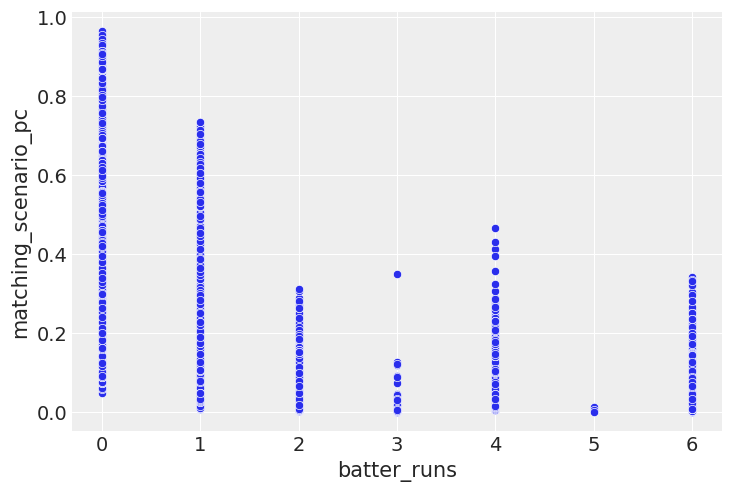

In [1041]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'batter_runs',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='venue', ylabel='matching_scenario_pc'>

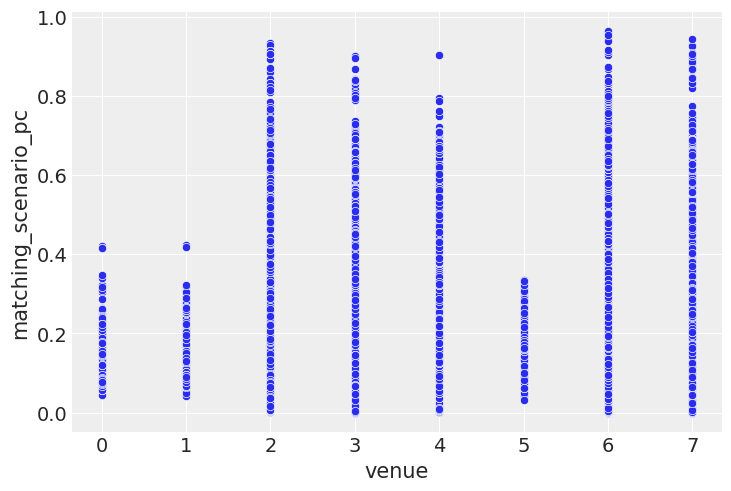

In [1042]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'venue',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='is_legal_delivery', ylabel='matching_scenario_pc'>

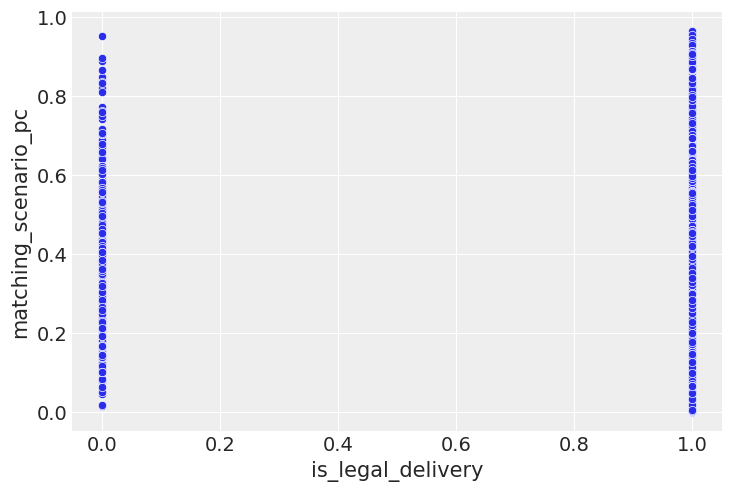

In [1043]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'is_legal_delivery',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='over', ylabel='matching_scenario_pc'>

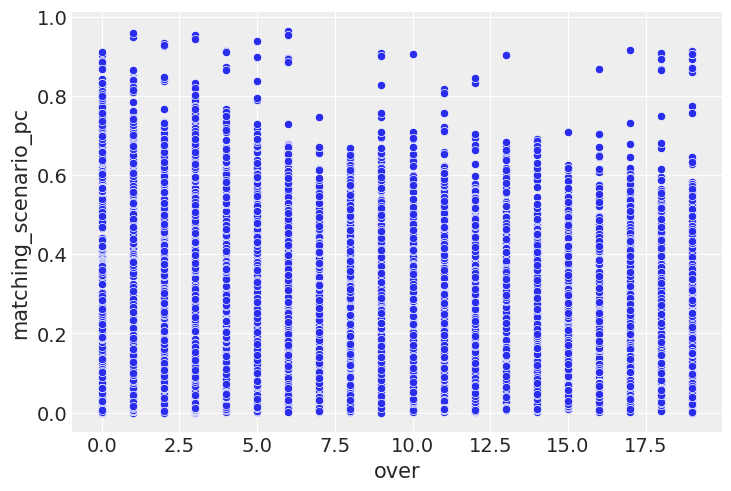

In [1044]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'over',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='inning', ylabel='matching_scenario_pc'>

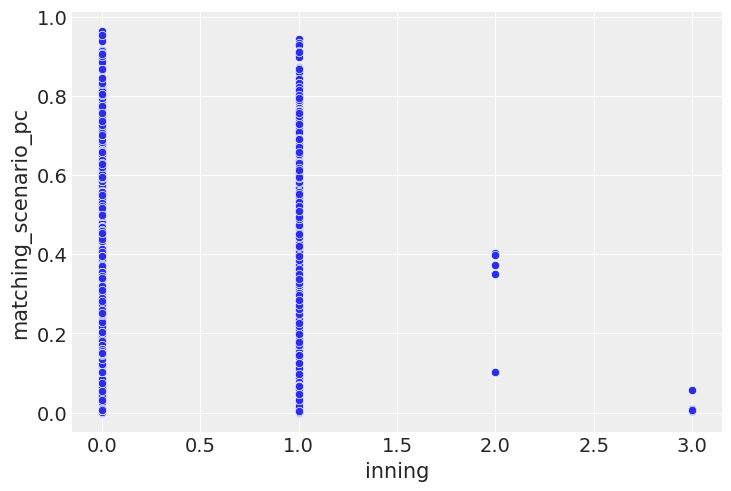

In [1045]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'inning',
    y = 'matching_scenario_pc'
)

In [ ]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'is_wicket',
    y = 'matching_scenario_pc'
)

In [ ]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'batter_featured_id',
    y = 'matching_scenario_pc'
)

In [ ]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'bowler_featured_id',
    y = 'matching_scenario_pc'
)

In [1049]:
train_combined_df.batter_featured_id.unique().shape 

(122,)

## Try traditional ML with OHE

In [84]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoders = {}
train_ohe_features = {}
test_ohe_features = {}
for feature in ['batter','bowler','venue','over','inning','wickets_fallen']:
    ohe = OneHotEncoder(sparse=False)
    all_features = pd.concat([train_match_state_df[[feature]],
                             test_season_match_state_df[[feature]]])
    ohe.fit(all_features)
    train_features = ohe.transform(train_match_state_df[[feature]])
    test_features = ohe.transform(test_season_match_state_df[[feature]])
    one_hot_encoders[feature] = ohe
    train_ohe_features[feature] = train_features
    test_ohe_features[feature] = test_features

In [85]:
for feature in ['innings_strike_rate']:
    train_ohe_features[feature] = train_match_state_df[[feature]].values
    test_ohe_features[feature] = test_season_match_state_df[[feature]].values

In [86]:
train_ohe_feature_array = np.hstack(train_ohe_features.values())
test_ohe_feature_array = np.hstack(test_ohe_features.values())

In [87]:
train_ohe_feature_array.shape

(243125, 2802)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_ohe_feature_array,
        train_bowling_outcomes_df['batter_runs'])

In [1592]:
predictions_rfc = clf.predict(test_ohe_feature_array)

In [1593]:
predictions_rfc_df = pd.DataFrame({'batter_runs': predictions_rfc})

<AxesSubplot: >

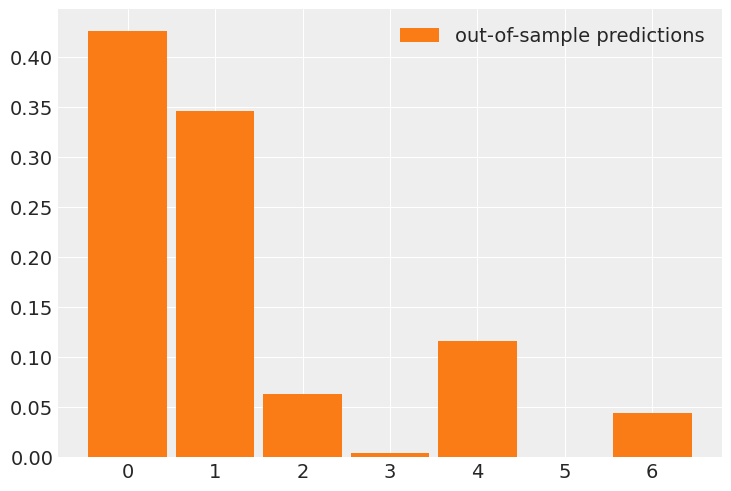

In [1594]:
az.plot_dist(train_bowling_outcomes_df.batter_runs, 
             color='C1', 
             label = 'out-of-sample predictions')

<AxesSubplot: >

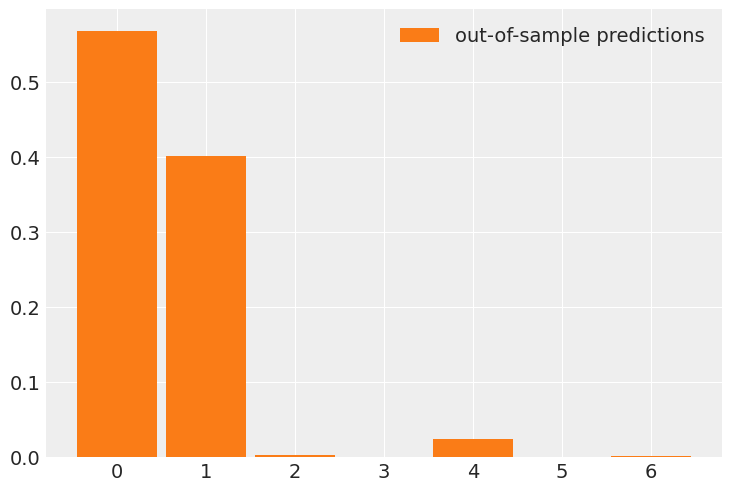

In [1595]:
az.plot_dist(predictions_rfc_df.batter_runs, 
             color='C1', 
             label = 'out-of-sample predictions')